# Imports

In [1]:
from capymoa.regressor import FIMTDD, AdaptiveRandomForestRegressor
from capymoa.stream import Schema
from capymoa.instance import RegressionInstance
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In this notebook I aim to go through all the naive approaches that were already done, and I'll build on them with some of my own ideas (+ look at a couple of applications).

# Naive Approaches

I tried the:
- Naive all per stop regressor
- Naive per stop regressor
- Naive regressor
- Naive chunked regressor

I wanted to try the timestamp naive chunked regressor but running time was too long.

## Naive All Per Stop Regressor

In [2]:
class NaiveAllPerStopRegressor:
    def __init__(self, stop_ids, window_size=5):
        '''
        Inits regressor for naive approach

        Args:
            stop_ids (str[]): List of stop ids from file
            window_size (int): Number of lag features for model to predict on
        '''

        # Set window sizes and create
        self.window_size = window_size
        self.window = []
        # Create custom schema for dataset
        self.schema = Schema.from_custom(
            feature_names=[
                f"feature_{f}_t{-t}"
                for t in range(self.window_size)
                for f in range(len(stop_ids))
            ],
            dataset_name="OccupancyPredict",
            target_type="numeric"
        )
        # Using FIMTDD as regressor
        self.regressors = {stop_id: FIMTDD(self.schema) for stop_id in stop_ids}
        self.log = {stop_id:[] for stop_id in stop_ids}

    def update_window(self, value):
        """
        Updates regressor windows with an instance

        Args:
            value (int): value of instance
        """
        # Sliding window
        if len(self.window) == self.window_size:
            self.window.pop(0)
        self.window.append(value)

    def get_window(self):
        """
        Flatten the rows of data in window into a 1d array
        """
        return [item for sublist in self.window for item in sublist]

    def train(self, stop_id, target, features):
        """
        Trains regressor for stop_id on an instance

        Args:
            stop_id (str): String of stop_id data comes from
            target (float): Target value to predict
            features (array): Data to use to predict the value
        """

        # Update window
        self.update_window(features)

        # If there aren't enough instances to implement lag features can't train
        if len(self.window) < self.window_size:
            return
        
        # Build lag features and train regressor
        x = np.array(self.get_window())
        instance = RegressionInstance.from_array(self.schema, x, target)
        self.log[str(int(stop_id))].append({'x':x,'target':target})
        self.regressors[str(int(stop_id))].train(instance)

    def predict(self, stop_id):
        """
        Predicts value

        Args:
            stop_id (str): String of stop_id to predict
        """

        # Can't predict without lag features
        if len(self.window) < self.window_size:
            return 0.0
        
        # Build lag features, predict
        x = np.array(self.get_window())
        instance = RegressionInstance.from_array(self.schema, x, 0.0) # Needs target
        return self.regressors[str(int(stop_id))].predict(instance)

In [3]:
selected_model = NaiveAllPerStopRegressor

100%|█████████████████████████████████| 218400/218400 [01:43<00:00, 2107.74it/s]


Final MAE: 10.786
Final RMSE: 27.528


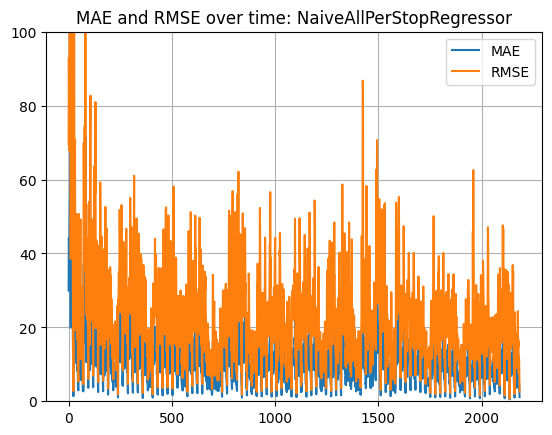

In [4]:
# Load in csv as dataframe
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

stop_ids = [
    "125960550",
    "230565994",
    "258781031",
    "43768720",
    "44072192",
    "44783654",
    "44783914",
    "44784438",
    "45833547",
    "47568123" ]

# Init model
model = selected_model(stop_ids)

# Keeping track of errors
total_abs_error = 0.0
total_squared_error = 0.0
count = 0

# Window error tracking
error_window = 100
abs_error_buf = 0.0
sqrd_error_buf = 0.0
buf_count = 0
mae_list = []
rmse_list = []

# Loop over values send to regressor as stream
for _, row in tqdm(df.iterrows(), total=len(df)):
        
    y_value = row['f30avg']

    # Predict and get error
    pred = model.predict(row['stop'])
    error = pred - y_value

    # Update total errors
    total_abs_error += abs(error)
    total_squared_error += error ** 2
    count += 1

    # Update buf errors
    abs_error_buf += abs(error)
    sqrd_error_buf += error ** 2
    buf_count += 1

    # Train on instance
    model.train(row['stop'], y_value, row[stop_ids])

    # Add windowed error
    if buf_count == error_window:
        mae = abs_error_buf / error_window
        rmse = np.sqrt(sqrd_error_buf / error_window)
        mae_list.append(mae)
        rmse_list.append(rmse)

        # Reset
        abs_error_buf = 0.0
        sqrd_error_buf = 0.0
        buf_count = 0

# Get final metrics
mae = total_abs_error / count
rmse = np.sqrt(total_squared_error / count)

print(f"Final MAE: {mae:.3f}")
print(f"Final RMSE: {rmse:.3f}")

# Plot mae and rmse over windows
plt.figure()
plt.plot(mae_list, label="MAE")
plt.plot(rmse_list, label="RMSE")
plt.title("MAE and RMSE over time: "+selected_model.__name__)
plt.legend()
plt.grid(True)
plt.ylim((0,100))
plt.show()

In [5]:
model.log['125960550'][0]

{'x': array([1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 8., 6., 0., 0., 0., 0., 0., 1.]),
 'target': np.float64(1.0)}

This has one model for every stop. Input is lag information about all stops from 5min data. Output is f30avg label.

## Naive Per Stop

In [6]:
class NaivePerStopRegressor:
    def __init__(self, stop_ids, num_features=5):
        '''
        Inits regressor for naive approach

        Args:
            stop_ids (str[]): List of stop ids from file
            num_features (int): Number of lag features for model to predict on
        '''
        self.num_features = num_features
        # Set window sizes and create
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        # Create custom schema for dataset
        self.schema = Schema.from_custom(
            feature_names=[str(i) for i in range(num_features)],
            dataset_name="OccupancyPredict",
            target_type="numeric"
        )
        # Using FIMTDD as regressor
        self.regressors = {stop_id: FIMTDD(self.schema) for stop_id in stop_ids}
        self.log = {stop_id: [] for stop_id in stop_ids}

    def update_window(self, stop_id, value):
        """
        Updates regressor winodws with an instance

        Args:
            stop_id (str): String of stop_id
            value (int): value of instance
        """
        window = self.windows[stop_id]
        # Sliding window
        if len(window) == self.window_size:
            window.pop(0)
        window.append(value)

    def train(self, stop_id, target, feature):
        """
        Trains regressor on an instance

        Args:
            stop_id (str): String of stop_id data comes from
            target (float): Target value to predict
        """
        # Update window
        self.update_window(stop_id, feature)

        window = self.windows[stop_id]
        # If there aren't enough instances to implement lag features can't train
        if len(window) < self.num_features:
            return
        
        # Build lag features and train regressor
        x = np.array(window)
        instance = RegressionInstance.from_array(self.schema, x, target)
        self.log[stop_id].append({'x':x,'target':target})
        self.regressors[stop_id].train(instance)

    def predict(self, stop_id):
        """
        Predicts value

        Args:
            stop_id (str): String of stop_id to predict from
        """
        window = self.windows[stop_id]
        # Can't predict without lag features
        if len(window) < self.num_features:
            return 0.0
        
        # Build lag features, predict
        x = np.array(window)
        instance = RegressionInstance.from_array(self.schema, x, 0.0) # Needs target
        return self.regressors[stop_id].predict(instance)

In [7]:
selected_model = NaivePerStopRegressor

100%|███████████████████████████████████| 21840/21840 [00:11<00:00, 1856.00it/s]


Final MAE: 9.077
Final RMSE: 21.013


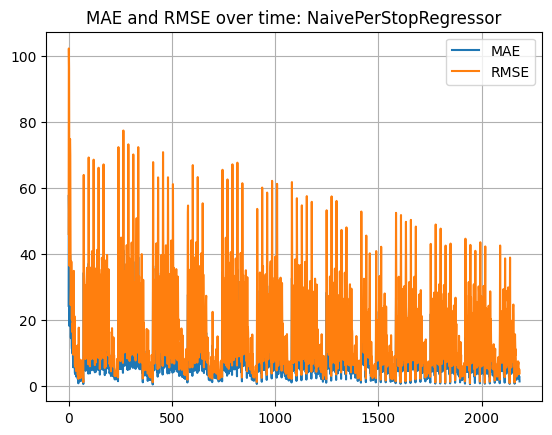

In [8]:
# Load in csv as dataframe
df = pd.read_csv("loader_f30avg_old.csv", index_col=0)

# Get all stop ids
stop_ids = df.columns.to_list()

feature_ids = [
    "125960550",
    "230565994",
    "258781031",
    "43768720",
    "44072192",
    "44783654",
    "44783914",
    "44784438",
    "45833547",
    "47568123" ]

target_ids = [
    "125960550_f30avg",
    "230565994_f30avg",
    "258781031_f30avg",
    "43768720_f30avg",
    "44072192_f30avg",
    "44783654_f30avg",
    "44783914_f30avg",
    "44784438_f30avg",
    "45833547_f30avg",
    "47568123_f30avg"
    ]

# Init model
model = selected_model(target_ids)

# Keeping track of errors
total_abs_error = 0.0
total_squared_error = 0.0
count = 0

# Window error tracking
error_window = 100
abs_error_buf = 0.0
sqrd_error_buf = 0.0
buf_count = 0
mae_list = []
rmse_list = []

# Loop over values send to regressor as stream
for _, row in tqdm(df.iterrows(), total=len(df)):
    for stop_id in target_ids:

        feature_value = row[stop_id.split("_")[0]]

        value = row[stop_id]

        # Predict and get error
        pred = model.predict(stop_id)
        error = pred - value

        # Update total errors
        total_abs_error += abs(error)
        total_squared_error += error ** 2
        count += 1

        # Update buf errors
        abs_error_buf += abs(error)
        sqrd_error_buf += error ** 2
        buf_count += 1

        # Train on instance
        model.train(stop_id, value, feature_value)

        # Add windowed error
        if buf_count == error_window:
            mae = abs_error_buf / error_window
            rmse = np.sqrt(sqrd_error_buf / error_window)
            mae_list.append(mae)
            rmse_list.append(rmse)

            # Reset
            abs_error_buf = 0.0
            sqrd_error_buf = 0.0
            buf_count = 0

# Get final metrics
mae = total_abs_error / count
rmse = np.sqrt(total_squared_error / count)

print(f"Final MAE: {mae:.3f}")
print(f"Final RMSE: {rmse:.3f}")

# Plot mae and rmse over windows
plt.figure()
plt.plot(mae_list, label="MAE")
plt.plot(rmse_list, label="RMSE")
plt.title("MAE and RMSE over time: "+selected_model.__name__)
plt.legend()
plt.grid(True)
plt.show()

In [9]:
model.log['125960550_f30avg'][0]

{'x': array([1, 1, 1, 1, 1]), 'target': 1.167}

This just has the lags for a singular stop. Input is lag information from 5min stop data. Output is f30avg label.

## Naive

In [10]:
class NaiveRegressor:
    def __init__(self, stop_ids, num_features=5):
        '''
        Inits regressor for naive approach

        Args:
            stop_ids (str[]): List of stop ids from file
            num_features (int): Number of lag features for model to predict on
        '''
        self.num_features = num_features
        # Set window sizes and create
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        # Create custom schema for dataset
        self.schema = Schema.from_custom(
            feature_names=[str(i) for i in range(num_features)],
            dataset_name="OccupancyPredict",
            target_type="numeric"
        )
        # Using FIMTDD as regressor
        self.regressor = FIMTDD(self.schema)
        self.log = []

    def update_window(self, stop_id, value):
        """
        Updates regressor winodws with an instance

        Args:
            stop_id (str): String of stop_id
            value (int): value of instance
        """
        window = self.windows[stop_id]
        # Sliding window
        if len(window) == self.window_size:
            window.pop(0)
        window.append(value)

    def train(self, stop_id, target):
        """
        Trains regressor on an instance

        Args:
            stop_id (str): String of stop_id data comes from
            target (float): Target value to predict
        """
        window = self.windows[stop_id]
        # If there aren't enough instances to implement lag features can't train
        if len(window) < self.num_features:
            self.update_window(stop_id, target)
            return
        
        # Build lag features and train regressor
        x = np.array(window)
        instance = RegressionInstance.from_array(self.schema, x, target)
        self.log.append({'x':x,'target':target})
        self.regressor.train(instance)
        self.update_window(stop_id, target)

    def predict(self, stop_id):
        """
        Predicts value

        Args:
            stop_id (str): String of stop_id to predict from
        """
        window = self.windows[stop_id]
        # Can't predict without lag features
        if len(window) < self.num_features:
            return 0.0
        
        # Build lag features, predict
        x = np.array(window)
        instance = RegressionInstance.from_array(self.schema, x, 0.0) # Needs target
        return self.regressor.predict(instance)

In [11]:
selected_model = NaiveRegressor

['125960550_f30avg', '230565994_f30avg', '258781031_f30avg', '43768720_f30avg', '44072192_f30avg', '44783654_f30avg', '44783914_f30avg', '44784438_f30avg', '45833547_f30avg', '47568123_f30avg']


100%|███████████████████████████████████| 21840/21840 [00:11<00:00, 1890.67it/s]


Final MAE: 2.792
Final RMSE: 6.257


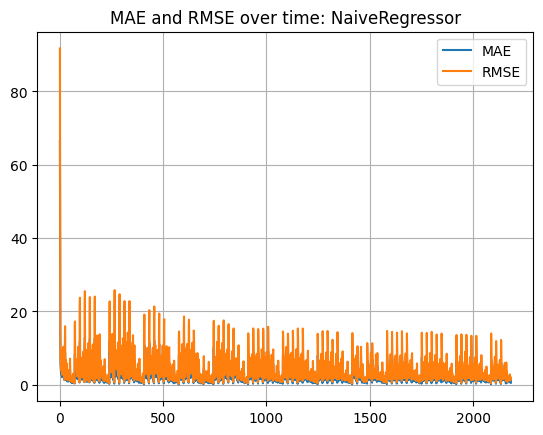

In [12]:
# Load in csv as dataframe
df = pd.read_csv("loader_f30avg_old.csv", index_col=0)

# Get all stop ids
stop_ids = df.columns.to_list()

stop_ids = [i for i in stop_ids if "_f30avg" in i]

print(stop_ids)

# Init model
model = selected_model(stop_ids)

# Keeping track of errors
total_abs_error = 0.0
total_squared_error = 0.0
count = 0

# Window error tracking
error_window = 100
abs_error_buf = 0.0
sqrd_error_buf = 0.0
buf_count = 0
mae_list = []
rmse_list = []

# Loop over values send to regressor as stream
for _, row in tqdm(df.iterrows(), total=len(df)):
    for stop_id in stop_ids:
        value = row[stop_id]

        # Predict and get error
        pred = model.predict(stop_id)
        error = pred - value

        # Update total errors
        total_abs_error += abs(error)
        total_squared_error += error ** 2
        count += 1

        # Update buf errors
        abs_error_buf += abs(error)
        sqrd_error_buf += error ** 2
        buf_count += 1

        # Train on instance
        model.train(stop_id, value)

        # Add windowed error
        if buf_count == error_window:
            mae = abs_error_buf / error_window
            rmse = np.sqrt(sqrd_error_buf / error_window)
            mae_list.append(mae)
            rmse_list.append(rmse)

            # Reset
            abs_error_buf = 0.0
            sqrd_error_buf = 0.0
            buf_count = 0

# Get final metrics
mae = total_abs_error / count
rmse = np.sqrt(total_squared_error / count)

print(f"Final MAE: {mae:.3f}")
print(f"Final RMSE: {rmse:.3f}")

# Plot mae and rmse over windows
plt.figure()
plt.plot(mae_list, label="MAE")
plt.plot(rmse_list, label="RMSE")
plt.title("MAE and RMSE over time: "+selected_model.__name__)
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.log[0]

{'x': array([1.   , 1.   , 1.   , 1.   , 1.167]), 'target': 1.5}

This predicts the next f30avg label based on the previous 5 f30avg labels. This not valid because it exploits data that in the setting, we won't have access to yet.

## Naive Chunked

In [14]:
class NaiveRegressorChunked:
    def __init__(self, stop_ids, num_features=5):
        '''
        Inits regressor for naive approach

        Args:
            stop_ids (str[]): List of stop ids from file
            num_features (int): Number of lag features for model to predict on
        '''
        self.num_features = num_features
        # Set window sizes and create
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        # Create custom schema for dataset
        self.schema = Schema.from_custom(
            feature_names=[str(i) for i in range(num_features)],
            dataset_name="OccupancyPredict",
            target_type="numeric"
        )
        # Using FIMTDD as regressor
        self.regressor = FIMTDD(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """
        Updates all per-stop lag windows using current occupancy data

        Args:
            row (pd.Series): A row from dataframe of occupancies per stop
        """
        for stop_id in self.windows.keys():
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def train(self, stop_id, target):
        """
        Trains regressor on an instance

        Args:
            stop_id (str): String of stop_id data comes from
            target (float): Target value to predict
        """
        window = self.windows[stop_id]
        # If there aren't enough instances to implement lag features can't train
        if len(window) < self.num_features:
            return
        
        # Build lag features and train regressor
        x = np.array(window)
        instance = RegressionInstance.from_array(self.schema, x, target)
        self.log.append({'x':x,'target':target})
        self.regressor.train(instance)

    def predict(self, stop_id):
        """
        Predicts value

        Args:
            stop_id (str): String of stop_id to predict from
        """
        window = self.windows[stop_id]
        # Can't predict without lag features
        if len(window) < self.num_features:
            return 0.0
        
        # Build lag features, predict
        x = np.array(window)
        instance = RegressionInstance.from_array(self.schema, x, 0.0) # Needs target
        return self.regressor.predict(instance)

In [15]:
selected_model = NaiveRegressorChunked

['125960550', '230565994', '258781031', '43768720', '44072192', '44783654', '44783914', '44784438', '45833547', '47568123']


100%|████████████████████████████████| 218400/218400 [00:21<00:00, 10239.64it/s]


Final MAE: 7.284
Final RMSE: 17.418


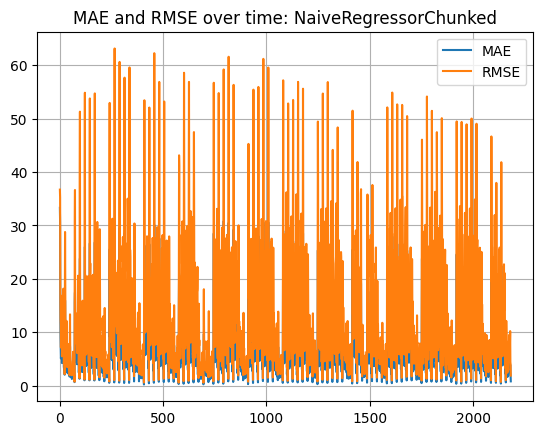

In [16]:
# Load in csv as dataframe
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

# Get all stop ids
stop_ids = df.columns.to_list()

stop_ids = [col for col in df.columns if col not in ["timestamp", "f30avg", "stop"]]

print(stop_ids)

# Init model
model = selected_model(stop_ids)

# Keeping track of errors
total_abs_error = 0.0
total_squared_error = 0.0
count = 0

# Window error tracking
error_window = 100
abs_error_buf = 0.0
sqrd_error_buf = 0.0
buf_count = 0
mae_list = []
rmse_list = []

# Loop over values send to regressor as stream
for _, row in tqdm(df.iterrows(), total=len(df)):
    model.update_all_windows(row)

    stop_id = str(int(row["stop"]))
    target = row["f30avg"]

    # Predict and get error
    pred = model.predict(stop_id)
    error = pred - target

    # Update total errors
    total_abs_error += abs(error)
    total_squared_error += error ** 2
    count += 1

    # Update buf errors
    abs_error_buf += abs(error)
    sqrd_error_buf += error ** 2
    buf_count += 1

    # Train on instance
    model.train(stop_id, target)

    # Add windowed error
    if buf_count == error_window:
        mae = abs_error_buf / error_window
        rmse = np.sqrt(sqrd_error_buf / error_window)
        mae_list.append(mae)
        rmse_list.append(rmse)

        # Reset
        abs_error_buf = 0.0
        sqrd_error_buf = 0.0
        buf_count = 0

# Get final metrics
mae = total_abs_error / count
rmse = np.sqrt(total_squared_error / count)

print(f"Final MAE: {mae:.3f}")
print(f"Final RMSE: {rmse:.3f}")

# Plot mae and rmse over windows
plt.figure()
plt.plot(mae_list, label="MAE")
plt.plot(rmse_list, label="RMSE")
plt.title("MAE and RMSE over time: "+selected_model.__name__)
plt.legend()
plt.grid(True)
plt.show()
     

In [17]:
model.log[0]

{'x': array([0., 0., 0., 0., 0.]), 'target': np.float64(0.667)}

This creates a shared autoregressive model. Takes five previous datapoints and predicts the next one. Does better than the others.

# New approaches

## Prequential evaluation

This is a prequential evaluation function that works with the 'naive chunked' data.

In [18]:
def prequential_evaluation(selected_model, df, context_df=None, error_window=100, plot=True, return_model = False):
    """
    Custom prequential evaluation function with optional context features.

    Args:
        selected_model (class): The model class to evaluate.
        df (pd.DataFrame): Index must be timestamp. Must contain 'stop', 'f30avg', and stop_id columns.
        context_df (pd.DataFrame, optional): Must also be indexed by timestamp.
        error_window (int): Window size for rolling error tracking.
        plot (bool): Whether to plot MAE and RMSE over time.

    Returns:
        (float, float, list, list): Final MAE, final RMSE, MAE list, RMSE list
    """
    # Ensure datetime index
    df.index = pd.to_datetime(df.index)
    if context_df is not None:
        context_df.index = pd.to_datetime(context_df.index)

    # Get stop IDs
    stop_ids = [col for col in df.columns if col not in ["f30avg", "stop"]]

    # Init model
    model = selected_model(stop_ids)

    # Error tracking
    total_abs_error = 0.0
    total_squared_error = 0.0
    count = 0

    abs_error_buf = 0.0
    sqrd_error_buf = 0.0
    buf_count = 0
    mae_list = []
    rmse_list = []

    # Iterate over stream
    for timestamp, row in tqdm(df.iterrows(), total=len(df)):
        # Update lag windows
        model.update_all_windows(row)

        stop_id = str(int(row["stop"]))
        target = row["f30avg"]

        # Get context features for this timestamp
        context_features = context_df.loc[timestamp] if context_df is not None and timestamp in context_df.index else None

        # Predict
        if context_features is not None:
            pred = model.predict(stop_id, context_features)
        else:
            pred = model.predict(stop_id)

        error = pred - target

        # Update errors
        total_abs_error += abs(error)
        total_squared_error += error ** 2
        count += 1

        abs_error_buf += abs(error)
        sqrd_error_buf += error ** 2
        buf_count += 1

        # Train
        if context_features is not None:
            model.train(stop_id, target, context_features)
        else:
            model.train(stop_id, target)

        # Rolling window errors
        if buf_count == error_window:
            mae = abs_error_buf / error_window
            rmse = np.sqrt(sqrd_error_buf / error_window)
            mae_list.append(mae)
            rmse_list.append(rmse)
            abs_error_buf = 0.0
            sqrd_error_buf = 0.0
            buf_count = 0

    # Final metrics
    mae = total_abs_error / count
    rmse = np.sqrt(total_squared_error / count)

    print(f"Final MAE: {mae:.3f}")
    print(f"Final RMSE: {rmse:.3f}")

    if plot:
        plt.figure()
        plt.plot(mae_list, label="MAE")
        plt.plot(rmse_list, label="RMSE")
        plt.title("MAE and RMSE over time: " + selected_model.__name__)
        plt.legend()
        plt.grid(True)
        plt.show()

    if return_model:
        return mae, rmse, mae_list, rmse_list, model
    else:
        return mae, rmse, mae_list, rmse_list


100%|████████████████████████████████| 218400/218400 [00:21<00:00, 10098.24it/s]


Final MAE: 7.284
Final RMSE: 17.418


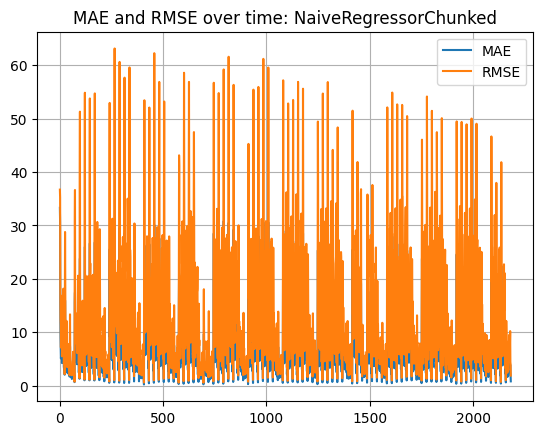

In [19]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)
mae, rmse, mae_list, rmse_list = prequential_evaluation(NaiveRegressorChunked, df)

## Super Naive Model

In [20]:
class SuperNaiveModel:
    def __init__(self, stop_ids, num_features=5):
        '''
        Trivial baseline regressor that predicts the mean of the most recent lag values.

        Args:
            stop_ids (str[]): List of stop IDs
            num_features (int): Number of lag values to average
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        self.log = []

    def update_all_windows(self, row):
        """
        Updates all per-stop lag windows with raw values.

        Args:
            row (pd.Series): A row from dataframe of occupancies per stop
        """
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def train(self, stop_id, target):
        """
        No training needed for this naive model, but log data for consistency/debugging.
        """
        window = self.windows[stop_id]
        self.log.append({'x': window.copy(), 'target': target})

    def predict(self, stop_id):
        """
        Predicts the average of the most recent lag values.

        Args:
            stop_id (str): Stop ID to predict for

        Returns:
            float: Mean of the lag values or 0.0 if not enough data
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0
        return float(np.mean(window))

100%|████████████████████████████████| 218400/218400 [00:12<00:00, 17150.36it/s]


Final MAE: 7.431
Final RMSE: 17.863


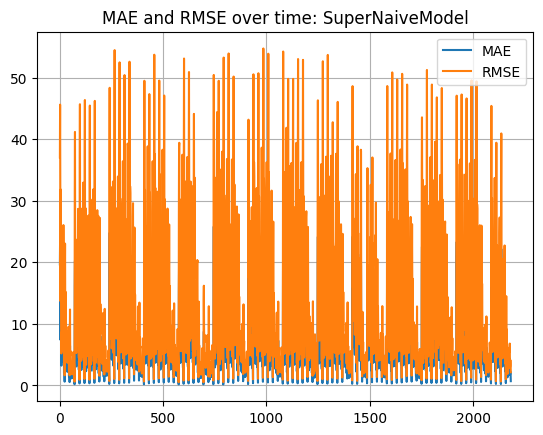

In [21]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)
mae, rmse, mae_list, rmse_list = prequential_evaluation(SuperNaiveModel, df)

## Integrated Models

To make a truly integrated model:
- We want to predict the difference between the means and the next 30 minute average
- We predict this difference using the differences between the lags

In [22]:
class NaiveRegressorIntegrated:
    def __init__(self, stop_ids, num_features=5):
        '''
        Differenced/integrated naive regressor.

        - Inputs: differences between consecutive values (length = num_features - 1)
        - Target: future value minus mean of recent lags
        - Prediction: predicted delta added to mean of recent lags

        Args:
            stop_ids (str[]): List of stop IDs
            num_features (int): Number of lag values to maintain
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}

        # Only use differences as features (length = num_features - 1)
        self.schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(num_features - 1)],
            dataset_name="OccupancyPredictIntegrated",
            target_type="numeric"
        )

        self.regressor = FIMTDD(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """
        Updates per-stop lag windows with raw values (not differenced yet).

        Args:
            row (pd.Series): A row from the dataframe with all stop values
        """
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def train(self, stop_id, target):
        """
        Trains on the delta from the mean of the current lag window.

        Args:
            stop_id (str): Stop ID
            target (float): Actual observed target value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return

        # Compute inputs and target delta
        diff_lags = np.diff(window)  # shape: (num_features - 1,)
        mean_lag = np.mean(window)
        delta_target = target - mean_lag

        instance = RegressionInstance.from_array(self.schema, diff_lags, delta_target)
        self.log.append({'x': diff_lags.copy(), 'mean': mean_lag, 'target': target, 'delta': delta_target})
        self.regressor.train(instance)

    def predict(self, stop_id):
        """
        Predicts the next value as: recent mean + predicted delta.

        Args:
            stop_id (str): Stop ID

        Returns:
            float: Predicted next value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        diff_lags = np.diff(window)
        mean_lag = np.mean(window)

        instance = RegressionInstance.from_array(self.schema, diff_lags, 0.0)
        predicted_delta = self.regressor.predict(instance)
        return mean_lag + predicted_delta

100%|█████████████████████████████████| 218400/218400 [00:31<00:00, 6945.29it/s]


Final MAE: 6.340
Final RMSE: 13.606


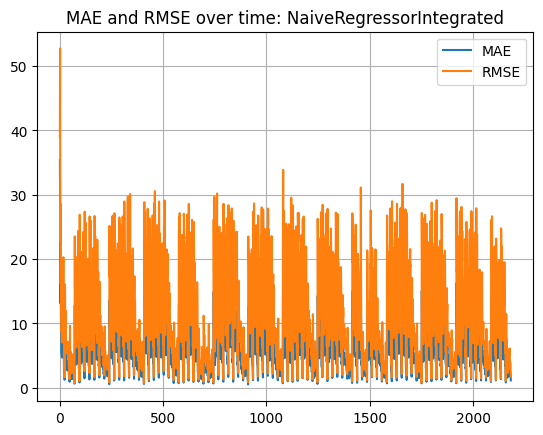

In [23]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)
mae, rmse, mae_list, rmse_list = prequential_evaluation(NaiveRegressorIntegrated, df)

## Exogenous regressors

In [24]:
df_contextual_data = pd.read_csv('additional_data_03-05_2024_lagged.csv', index_col=0)

In [25]:
class SeasonalRegressorIntegrated:
    def __init__(self, stop_ids, num_features=5):
        '''
        Seasonal integrated regressor using lag differences and cyclical time features.

        - Inputs: lag differences + time features (e.g., hour_sin, hour_cos)
        - Target: future value minus mean of recent lags
        - Prediction: predicted delta added to mean of recent lags
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}

        # Feature schema: lag diffs + 2 time features
        self.schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(num_features - 1)] + ["hour_sin", "hour_cos"],
            dataset_name="OccupancyPredictSeasonalIntegrated",
            target_type="numeric"
        )

        self.regressor = FIMTDD(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """Updates per-stop lag windows with raw values."""
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def train(self, stop_id, target, context_features):
        """
        Trains on the delta from the mean of the current lag window with time features.

        Args:
            stop_id (str): Stop ID
            target (float): Actual observed target value
            context_features (pd.Series): Must include hour_sin and hour_cos
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return

        diff_lags = np.diff(window)  # shape: (num_features - 1,)
        mean_lag = np.mean(window)
        delta_target = target - mean_lag

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos"]].values])
        instance = RegressionInstance.from_array(self.schema, features, delta_target)

        self.log.append({'x': features.copy(), 'mean': mean_lag, 'target': target, 'delta': delta_target})
        self.regressor.train(instance)

    def predict(self, stop_id, context_features):
        """
        Predicts the next value using lag window and time features.

        Args:
            stop_id (str): Stop ID
            context_features (pd.Series): Must include hour_sin and hour_cos

        Returns:
            float: Predicted next value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        diff_lags = np.diff(window)
        mean_lag = np.mean(window)

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos"]].values])
        instance = RegressionInstance.from_array(self.schema, features, 0.0)
        predicted_delta = self.regressor.predict(instance)

        return mean_lag + predicted_delta

100%|█████████████████████████████████| 218400/218400 [02:19<00:00, 1567.29it/s]


Final MAE: 5.860
Final RMSE: 11.909


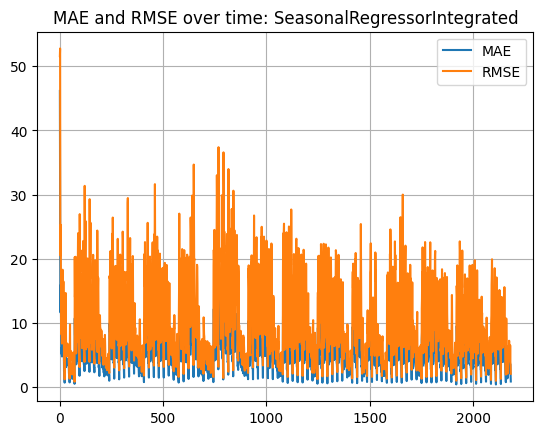

In [26]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

mae, rmse, mae_list, rmse_list, seasonal_integrated_fimtdd = prequential_evaluation(
    SeasonalRegressorIntegrated,
    df,
    context_df=df_contextual_data,
    return_model = True
)

In [27]:
class TimeRegressorIntegrated:
    def __init__(self, stop_ids, num_features=5):
        '''
        Seasonal integrated regressor using lag differences and cyclical time features.

      ,"Is_Weekend","Public_Holiday","Is_Event"  - Inputs: lag differences + time features (e.g., hour_sin, hour_cos)
        - Target: future value minus mean of recent lags
        - Prediction: predicted delta added to mean of recent lags
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}

        # Feature schema: lag diffs + 2 time features
        self.schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(num_features - 1)] + ["hour_sin", "hour_cos","Is_Weekend"],
            dataset_name="OccupancyPredictSeasonalIntegrated",
            target_type="numeric"
        )

        self.regressor = FIMTDD(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """Updates per-stop lag windows with raw values."""
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def train(self, stop_id, target, context_features):
        """
        Trains on the delta from the mean of the current lag window with time features.

        Args:
            stop_id (str): Stop ID
            target (float): Actual observed target value
            context_features (pd.Series): Must include hour_sin and hour_cos
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return

        diff_lags = np.diff(window)  # shape: (num_features - 1,)
        mean_lag = np.mean(window)
        delta_target = target - mean_lag

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos","Is_Weekend"]].values])
        instance = RegressionInstance.from_array(self.schema, features, delta_target)

        self.log.append({'x': features.copy(), 'mean': mean_lag, 'target': target, 'delta': delta_target})
        self.regressor.train(instance)

    def predict(self, stop_id, context_features):
        """
        Predicts the next value using lag window and time features.

        Args:
            stop_id (str): Stop ID
            context_features (pd.Series): Must include hour_sin and hour_cos

        Returns:
            float: Predicted next value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        diff_lags = np.diff(window)
        mean_lag = np.mean(window)

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos","Is_Weekend"]].values])
        instance = RegressionInstance.from_array(self.schema, features, 0.0)
        predicted_delta = self.regressor.predict(instance)

        return mean_lag + predicted_delta

100%|█████████████████████████████████| 218400/218400 [02:20<00:00, 1553.96it/s]


Final MAE: 6.553
Final RMSE: 15.512


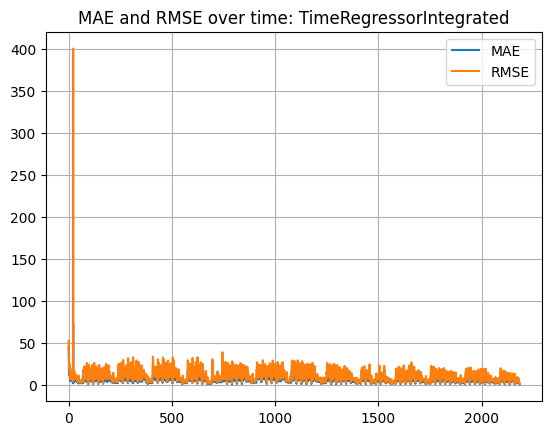

In [28]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

mae, rmse, mae_list, rmse_list = prequential_evaluation(
    TimeRegressorIntegrated,
    df,
    context_df=df_contextual_data
)

## Adaptive random forests

ARF doesn't absolutely blow up like FIMTDD does with exogenous regressors, but it also isn't as good as a simple FIMTDD regressor

In [29]:
class TimeRegressorIntegratedARF:
    def __init__(self, stop_ids, num_features=5):
        '''
        Seasonal integrated regressor using lag differences and cyclical time features.

        - Inputs: lag differences + time features (e.g., hour_sin, hour_cos)
        - Target: future value minus mean of recent lags
        - Prediction: predicted delta added to mean of recent lags
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}

        # Feature schema: lag diffs + 2 time features
        self.schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(num_features - 1)] + ["hour_sin", "hour_cos","Is_Weekend","Public_Holiday","Is_Event"],
            dataset_name="OccupancyPredictSeasonalIntegrated",
            target_type="numeric"
        )

        self.regressor = AdaptiveRandomForestRegressor(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """Updates per-stop lag windows with raw values."""
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def train(self, stop_id, target, context_features):
        """
        Trains on the delta from the mean of the current lag window with time features.

        Args:
            stop_id (str): Stop ID
            target (float): Actual observed target value
            context_features (pd.Series): Must include hour_sin and hour_cos
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return

        diff_lags = np.diff(window)  # shape: (num_features - 1,)
        mean_lag = np.mean(window)
        delta_target = target - mean_lag

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos","Is_Weekend","Public_Holiday","Is_Event"]].values])
        instance = RegressionInstance.from_array(self.schema, features, delta_target)

        self.log.append({'x': features.copy(), 'mean': mean_lag, 'target': target, 'delta': delta_target})
        self.regressor.train(instance)

    def predict(self, stop_id, context_features):
        """
        Predicts the next value using lag window and time features.

        Args:
            stop_id (str): Stop ID
            context_features (pd.Series): Must include hour_sin and hour_cos

        Returns:
            float: Predicted next value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        diff_lags = np.diff(window)
        mean_lag = np.mean(window)

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos","Is_Weekend","Public_Holiday","Is_Event"]].values])
        instance = RegressionInstance.from_array(self.schema, features, 0.0)
        predicted_delta = self.regressor.predict(instance)

        return mean_lag + predicted_delta

100%|██████████████████████████████████| 218400/218400 [03:49<00:00, 951.34it/s]


Final MAE: 7.058
Final RMSE: 14.437


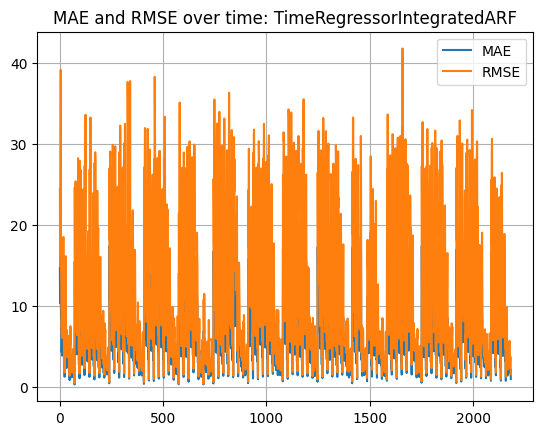

In [30]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

mae, rmse, mae_list, rmse_list = prequential_evaluation(
    TimeRegressorIntegratedARF,
    df,
    context_df=df_contextual_data
)

In [31]:
class ExogenousRegressorIntegratedARF:
    def __init__(self, stop_ids, num_features=5):
        '''
        Seasonal integrated regressor using lag differences and cyclical time features.

        - Inputs: lag differences + time features (e.g., hour_sin, hour_cos)
        - Target: future value minus mean of recent lags
        - Prediction: predicted delta added to mean of recent lags
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}

        # Feature schema: lag diffs + 2 time features
        self.schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(num_features - 1)] + ['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve'],
            dataset_name="OccupancyPredictSeasonalIntegrated",
            target_type="numeric"
        )

        self.regressor = AdaptiveRandomForestRegressor(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """Updates per-stop lag windows with raw values."""
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def train(self, stop_id, target, context_features):
        """
        Trains on the delta from the mean of the current lag window with time features.

        Args:
            stop_id (str): Stop ID
            target (float): Actual observed target value
            context_features (pd.Series): Must include hour_sin and hour_cos
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return

        diff_lags = np.diff(window)  # shape: (num_features - 1,)
        mean_lag = np.mean(window)
        delta_target = target - mean_lag

        features = np.concatenate([diff_lags, context_features[['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve']].values])
        instance = RegressionInstance.from_array(self.schema, features, delta_target)

        self.log.append({'x': features.copy(), 'mean': mean_lag, 'target': target, 'delta': delta_target})
        self.regressor.train(instance)

    def predict(self, stop_id, context_features):
        """
        Predicts the next value using lag window and time features.

        Args:
            stop_id (str): Stop ID
            context_features (pd.Series): Must include hour_sin and hour_cos

        Returns:
            float: Predicted next value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        diff_lags = np.diff(window)
        mean_lag = np.mean(window)

        features = np.concatenate([diff_lags, context_features[['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve']].values])
        instance = RegressionInstance.from_array(self.schema, features, 0.0)
        predicted_delta = self.regressor.predict(instance)

        return mean_lag + predicted_delta

100%|██████████████████████████████████| 218400/218400 [04:28<00:00, 814.06it/s]


Final MAE: 6.962
Final RMSE: 14.472


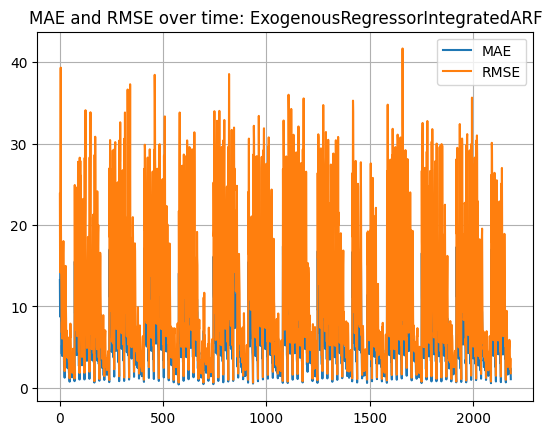

In [32]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

mae, rmse, mae_list, rmse_list, arf_model = prequential_evaluation(
    ExogenousRegressorIntegratedARF,
    df,
    context_df=df_contextual_data,
    return_model = True
)

# Application 1: Feature Importances

The ARF model can be broken down using streaming feature attribution.

In [33]:
ex_schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(5 - 1)] + ['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve'],
            dataset_name="OccupancyPredictSeasonalIntegrated",
            target_type="numeric"
        )

def predict_with_arf_model(model,x):
    features = np.concatenate([[0,0,0,0],x])
    instance = RegressionInstance.from_array(ex_schema, features, 0.0)
    return model.regressor.predict(instance)

In [34]:
class StreamingFeatureAttributionArray:
    def __init__(self, model, predict_fn, feature_names, baseline_strategy="zero", perturb_fn=None):
        """
        Args:
            model: Trained CapyMOA model (not used directly, passed to predict_fn)
            predict_fn: Function (model, x_array) -> prediction
            feature_names: List of feature names in the same order as array input
            baseline_strategy: "zero" or "mean"
            perturb_fn: Optional function to perturb values (value, feature_name) -> new_value
        """
        self.model = model
        self.predict_fn = predict_fn
        self.feature_names = feature_names
        self.baseline_strategy = baseline_strategy
        self.perturb_fn = perturb_fn

    def explain(self, x):
        """
        Compute per-feature attribution by perturbing each feature.

        Args:
            x (np.ndarray): 1D input array with shape (n_features,)

        Returns:
            dict: feature_name -> importance score
        """
        x = np.array(x)
        base_pred = self.predict_fn(self.model, x)

        attributions = {}
        for i, name in enumerate(self.feature_names):
            x_perturbed = x.copy()

            if self.perturb_fn:
                x_perturbed[i] = self.perturb_fn(x[i], name)
            elif self.baseline_strategy == "zero":
                x_perturbed[i] = 0
            else:
                raise NotImplementedError("Only 'zero' baseline is currently supported")

            perturbed_pred = self.predict_fn(self.model, x_perturbed)
            attributions[name] = base_pred - perturbed_pred

        return attributions

In [35]:
feature_names = ['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve']

explainer = StreamingFeatureAttributionArray(
    model=arf_model,
    predict_fn=predict_with_arf_model,
    feature_names=feature_names
)
all_explanations = []

# Iterate over each row in the dataset
for idx, row in tqdm(df_contextual_data[feature_names].iterrows(),total=len(df_contextual_data)):
    x = row.values
    explanation = explainer.explain(x)
    explanation["__row__"] = idx  # tag row index for reference
    all_explanations.append(explanation)

# Convert to DataFrame: rows = instances, columns = feature importances
explanations_df = pd.DataFrame(all_explanations).set_index("__row__")

100%|████████████████████████████████████| 21840/21840 [00:36<00:00, 593.06it/s]


In [36]:
mean_importance = explanations_df.abs().mean().sort_values(ascending=False)

print("Mean absolute feature importances:")
print(mean_importance)

Mean absolute feature importances:
hour_sin                   0.051073
windspeed_10m              0.006983
hour_cos                   0.002255
temperature_2m             0.001886
Day_Of_Week                0.000000
Public_Holiday             0.000000
Is_Event                   0.000000
Is_Weekend                 0.000000
Flu_Like_Symptoms_Count    0.000000
ibov_open                  0.000000
Dengue_Count               0.000000
precipitation              0.000000
cloudcover                 0.000000
pm2_5                      0.000000
ozone                      0.000000
us_aqi                     0.000000
onibus                     0.000000
metro                      0.000000
festival                   0.000000
trem                       0.000000
greve                      0.000000
dtype: float64


The only features that are useful for improving prediction are time, windspeed, and temperature.

# Application 2: Granger Causality

In [37]:
from statsmodels.tsa.stattools import grangercausalitytests

In [38]:
df_contextual_data_not_lagged = pd.read_csv('additional_data_03-05_2024_not_lagged.csv')[240:].reset_index(drop=True)

100%|█████████████████████████████████| 218400/218400 [02:21<00:00, 1545.12it/s]


Final MAE: 5.860
Final RMSE: 11.909


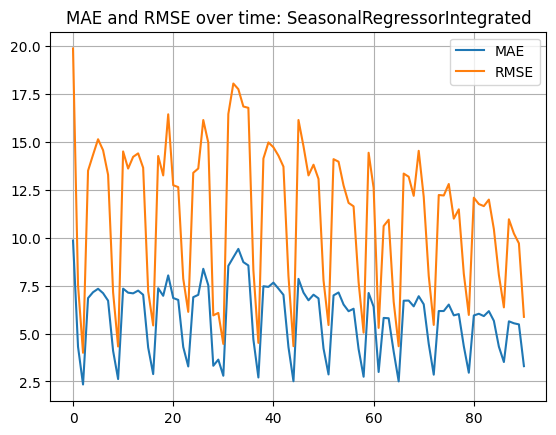

In [39]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

mae, rmse, mae_list, rmse_list_seasonal_integrated, seasonal_integrated_fimtdd = prequential_evaluation(
    SeasonalRegressorIntegrated,
    df,
    context_df=df_contextual_data,
    return_model = True,
    error_window=2400
)

In [40]:
df = df_contextual_data_not_lagged.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
columns = ['Flu_Like_Symptoms_Count','Dengue_Count','onibus','metro','festival','trem','greve']
daily_df = df[columns].resample('1D').mean()
daily_df = daily_df.reset_index()
daily_df = daily_df[:-1]

In [41]:
daily_df['Model_RMSE'] = rmse_list_seasonal_integrated

In [43]:
maxlag = 14

In [42]:
daily_df

,Timestamp,Flu_Like_Symptoms_Count,Dengue_Count,onibus,metro,festival,trem,greve,Model_RMSE
0,2024-03-01,505.0,276.0,46.0,5.0,10.0,13.0,0.0,19.861352
1,2024-03-02,97.0,53.0,51.0,5.0,10.0,10.0,0.0,7.521594
2,2024-03-03,110.0,72.0,45.0,0.0,12.0,21.0,0.0,3.993775
3,2024-03-04,524.0,306.0,46.0,4.0,8.0,13.0,4.0,13.489789
4,2024-03-05,414.0,229.0,42.0,4.0,10.0,8.0,7.0,14.320481
...,...,...,...,...,...,...,...,...,...
86,2024-05-26,73.0,38.0,48.0,5.0,15.0,9.0,17.0,6.363169
87,2024-05-27,222.0,117.0,74.0,7.0,10.0,13.0,69.0,10.957002
88,2024-05-28,192.0,111.0,84.0,0.0,12.0,9.0,100.0,10.212924
89,2024-05-29,155.0,95.0,50.0,5.0,7.0,8.0,30.0,9.700282


In [46]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.

    Citation: https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [49]:
granger_matrix = grangers_causation_matrix(daily_df,['Flu_Like_Symptoms_Count', 'Dengue_Count', 'onibus',
       'metro', 'festival', 'trem', 'greve', 'Model_RMSE'])

/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/en

In [53]:
granger_matrix < 0.05/(64) #Bonferroni correction

,Flu_Like_Symptoms_Count_x,Dengue_Count_x,onibus_x,metro_x,festival_x,trem_x,greve_x,Model_RMSE_x
Flu_Like_Symptoms_Count_y,False,False,False,False,False,True,False,True
Dengue_Count_y,False,False,False,False,False,True,False,True
onibus_y,False,False,False,False,False,False,False,False
metro_y,True,False,False,False,False,False,True,True
festival_y,False,False,False,True,False,False,True,False
trem_y,False,False,False,False,False,False,False,True
greve_y,True,True,False,False,False,False,False,False
Model_RMSE_y,False,False,True,False,False,False,True,False


The error of the model granger-causes flu-symptoms and dengue -- suggesting potential causation between public transport volumes and these diseases.

Searches for 'onibus' and 'greve' granger-cause the error of the model.